In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from pandas.io.json import json_normalize
import json
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("Libraries imported")

Libraries imported


In [2]:
corona = pd.read_csv('new york full.csv')

print('Covid-19 data imported')

Covid-19 data imported


In [3]:
with open('nyu_2451_34572-geojson.json') as json_data:
    nydf = json.load(json_data)

In [4]:
nydf

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
ny=nydf['features']

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in ny:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
corona.head()

,DATE_OF_INTEREST,BK_CASE_COUNT,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,BX_CASE_COUNT,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,MN_CASE_COUNT,MN_HOSPITALIZED_COUNT,MN_DEATH_COUNT,QN_CASE_COUNT,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,SI_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT
0,02/29/2020,0,4,0,0,4,0,1,2,0,0,4,0,0,0,0
1,03/01/2020,0,0,0,1,1,0,0,0,0,0,2,0,0,1,0
2,03/02/2020,0,5,0,0,9,0,0,4,0,0,5,0,0,0,0
3,03/03/2020,0,4,0,1,8,0,0,4,0,1,5,0,0,1,0
4,03/04/2020,1,6,0,0,6,0,2,5,0,2,3,0,0,2,0


In [10]:
corona.drop(corona.columns.difference(['DATE_OF_INTEREST','BK_CASE_COUNT','BX_CASE_COUNT','MN_CASE_COUNT','QN_CASE_COUNT','SI_CASE_COUNT']), 1, inplace= True)

In [11]:
corona.head()

,DATE_OF_INTEREST,BK_CASE_COUNT,BX_CASE_COUNT,MN_CASE_COUNT,QN_CASE_COUNT,SI_CASE_COUNT
0,02/29/2020,0,0,1,0,0
1,03/01/2020,0,1,0,0,0
2,03/02/2020,0,0,0,0,0
3,03/03/2020,0,1,0,1,0
4,03/04/2020,1,0,2,2,0


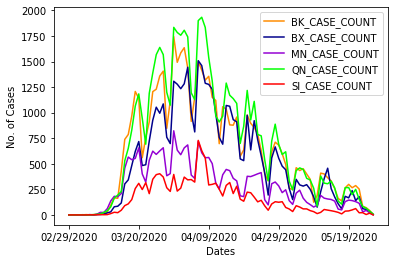

In [12]:
ax = plt.gca() #ax argument allows you to reuse an axis to plot multiple lines

corona.plot(kind='line',x='DATE_OF_INTEREST',y='BK_CASE_COUNT',color='darkorange', ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='BX_CASE_COUNT', color='darkblue',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='MN_CASE_COUNT', color='darkviolet',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='QN_CASE_COUNT', color='lime',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='SI_CASE_COUNT', color='red',ax=ax)

_ = plt.ylabel('No. of Cases')
_ = plt.xlabel('Dates')


plt.show()

The data has a significant difference between the boroughs, which is not clear enough to understand the impact of COVID-19 in a more holistic way.

First I retrieved data of population in each borough which will allow us to calculate the propensity of contracting COVID-19 cases at an individual level, and get a more magnified view of cases in the boroughs. Clearly, the boroughs have diverse areas and some tend to be more populated than others so it is necessary to evaluate the cases at the individual level, which will give us the clarity of the threat posed by the virus over time in New York. For this we'll evaluate the likeliness of contracting the virus each day by diving the number of cases on a given day by the total population. The result, although vague and very low will account for the disproportionate population. We will form new columns for this, for every borough, and see the line plot again.

In [13]:
#populations for each borough
bxp= 1418207 #Bronx
bkp= 2559903 #Brooklyn
mnp= 1628706 #Manhattan
qnp= 2253858 #Queens
sip= 476143 #Staten Island 

In [14]:
corona.dropna(inplace= True)

In [15]:
#creating new columns by calculating likeliness of contraction per day at an individual level 
#for reference, it is given by <borough name>PC (per capita)
corona['BrooklynPC'] = corona[['BK_CASE_COUNT']].apply(lambda arr: np.divide(arr,bkp))
corona['BronxPC'] = corona[['BX_CASE_COUNT']].apply(lambda arr: np.divide(arr,bxp))
corona['ManhattanPC'] = corona[['MN_CASE_COUNT']].apply(lambda arr: np.divide(arr,mnp))
corona['QueensPC'] = corona[['QN_CASE_COUNT']].apply(lambda arr: np.divide(arr,qnp))
corona['StatenIslandPC'] = corona[['SI_CASE_COUNT']].apply(lambda arr: np.divide(arr,sip))

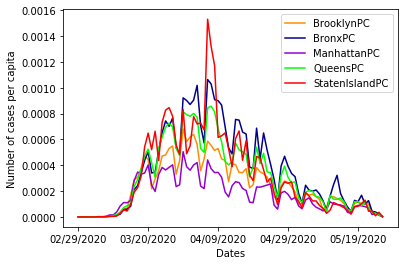

In [16]:
ax= plt.gca()

corona.plot(kind='line',x='DATE_OF_INTEREST',y='BrooklynPC', color='darkorange',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='BronxPC', color='darkblue',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='ManhattanPC', color='darkviolet',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='QueensPC', color='lime',ax=ax)
corona.plot(kind='line',x='DATE_OF_INTEREST',y='StatenIslandPC', color='red',ax=ax)

_ = plt.ylabel('Number of cases per capita')
_ = plt.xlabel('Dates')


plt.show()


We can see how the data changes when we account for population difference. Staten Island, that was previously low on the graph, suddenly peaks above other boroughs and the visuals change drastically.

In [17]:
corona.head()

,DATE_OF_INTEREST,BK_CASE_COUNT,BX_CASE_COUNT,MN_CASE_COUNT,QN_CASE_COUNT,SI_CASE_COUNT,BrooklynPC,BronxPC,ManhattanPC,QueensPC,StatenIslandPC
0,02/29/2020,0,0,1,0,0,0.000000e+00,0.000000e+00,6.139844e-07,0.000000e+00,0.0
1,03/01/2020,0,1,0,0,0,0.000000e+00,7.051157e-07,0.000000e+00,0.000000e+00,0.0
2,03/02/2020,0,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,03/03/2020,0,1,0,1,0,0.000000e+00,7.051157e-07,0.000000e+00,4.436837e-07,0.0
4,03/04/2020,1,0,2,2,0,3.906398e-07,0.000000e+00,1.227969e-06,8.873673e-07,0.0


Let's clean up our table a little bit more.

In [18]:
corona.set_index('DATE_OF_INTEREST', inplace= True)

In [19]:
corona.index = pd.to_datetime(corona.index, infer_datetime_format = True)

We shall now evaluate the boroughs independently for further analysis. For this we'll divide them into separate dataframes.

In [20]:
selected_columns=corona[["BK_CASE_COUNT","BrooklynPC"]]
bk=selected_columns.copy()

selected_columns=corona[["BX_CASE_COUNT","BronxPC"]]
bx=selected_columns.copy()

selected_columns1=corona[["MN_CASE_COUNT","ManhattanPC"]]
mn=selected_columns1.copy()

selected_columns2=corona[["QN_CASE_COUNT","QueensPC"]]
qn=selected_columns2.copy()

selected_columns3=corona[["SI_CASE_COUNT","StatenIslandPC"]]
si=selected_columns3.copy()

bk.head()

,BK_CASE_COUNT,BrooklynPC
DATE_OF_INTEREST,,
2020-02-29,0,0.000000e+00
2020-03-01,0,0.000000e+00
2020-03-02,0,0.000000e+00
2020-03-03,0,0.000000e+00
2020-03-04,1,3.906398e-07


In [21]:
#making the table more easy to interpret
bk.rename(columns={'BK_CASE_COUNT':'NewCases','BrooklynPC':'CasesPC'},inplace=True)
bx.rename(columns={'BX_CASE_COUNT':'NewCases','BronxPC':'CasesPC'},inplace=True)
mn.rename(columns={'MN_CASE_COUNT':'NewCases','ManhattanPC':'CasesPC'},inplace=True)
qn.rename(columns={'QN_CASE_COUNT':'NewCases','QueensPC':'CasesPC'},inplace=True)
si.rename(columns={'SI_CASE_COUNT':'NewCases','StatenIslandPC':'CasesPC'},inplace=True)

We shall now create columns for total cases on an increasing order from the day of inception of cases.

In [22]:
bk["TotalCases"]=bk["NewCases"].cumsum()
bx["TotalCases"]=bx["NewCases"].cumsum()
mn["TotalCases"]=mn["NewCases"].cumsum()
qn["TotalCases"]=qn["NewCases"].cumsum()
si["TotalCases"]=si["NewCases"].cumsum()

In [23]:
bk.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,0,0.000000e+00,0
2020-03-01,0,0.000000e+00,0
2020-03-02,0,0.000000e+00,0
2020-03-03,0,0.000000e+00,0
2020-03-04,1,3.906398e-07,1


In [24]:
bk["NewCases"].replace(np.nan,0,inplace=True)
bx["NewCases"].replace(np.nan,0,inplace=True)
mn["NewCases"].replace(np.nan,0,inplace=True)
qn["NewCases"].replace(np.nan,0,inplace=True)
si["NewCases"].replace(np.nan,0,inplace=True)

In [25]:
bk.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,0,0.000000e+00,0
2020-03-01,0,0.000000e+00,0
2020-03-02,0,0.000000e+00,0
2020-03-03,0,0.000000e+00,0
2020-03-04,1,3.906398e-07,1


In [26]:
bx.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,0,0.000000e+00,0
2020-03-01,1,7.051157e-07,1
2020-03-02,0,0.000000e+00,1
2020-03-03,1,7.051157e-07,2
2020-03-04,0,0.000000e+00,2


In [27]:
mn.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,1,6.139844e-07,1
2020-03-01,0,0.000000e+00,1
2020-03-02,0,0.000000e+00,1
2020-03-03,0,0.000000e+00,1
2020-03-04,2,1.227969e-06,3


In [28]:
qn.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,0,0.000000e+00,0
2020-03-01,0,0.000000e+00,0
2020-03-02,0,0.000000e+00,0
2020-03-03,1,4.436837e-07,1
2020-03-04,2,8.873673e-07,3


In [29]:
si.head()

,NewCases,CasesPC,TotalCases
DATE_OF_INTEREST,,,
2020-02-29,0,0.0,0
2020-03-01,0,0.0,0
2020-03-02,0,0.0,0
2020-03-03,0,0.0,0
2020-03-04,0,0.0,0


Let's use time series to forecast when the threat posed by the virus will be minimal in each borough. First, we will fit the curve in each dataframe using TotalCasesPC and NewCasesPC columns, using scipy library's optimize and curve_fit functions.

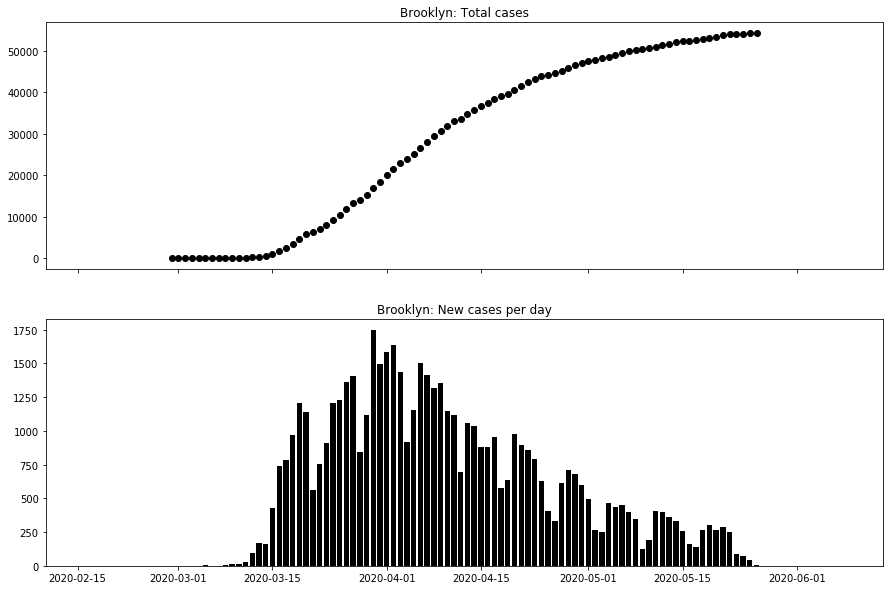

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
ax[0].scatter(bk.index, bk["TotalCases"].values, color="black")
ax[0].set(title="Brooklyn: Total cases")
ax[1].bar(bk.index, bk["NewCases"].values, color="black")
ax[1].set(title="Brooklyn: New cases per day")
plt.show()

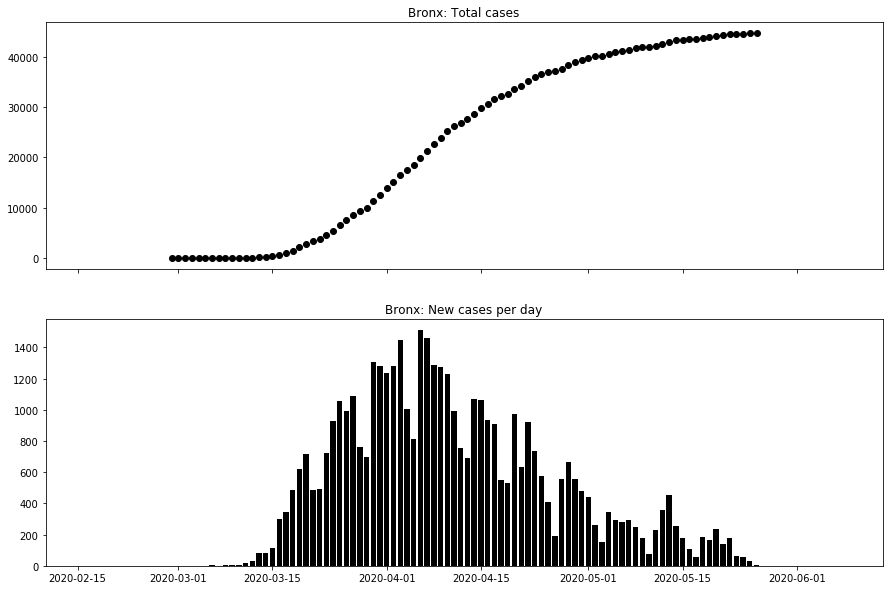

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
ax[0].scatter(bx.index, bx["TotalCases"].values, color="black")
ax[0].set(title="Bronx: Total cases")
ax[1].bar(bx.index, bx["NewCases"].values, color="black")
ax[1].set(title="Bronx: New cases per day")
plt.show()

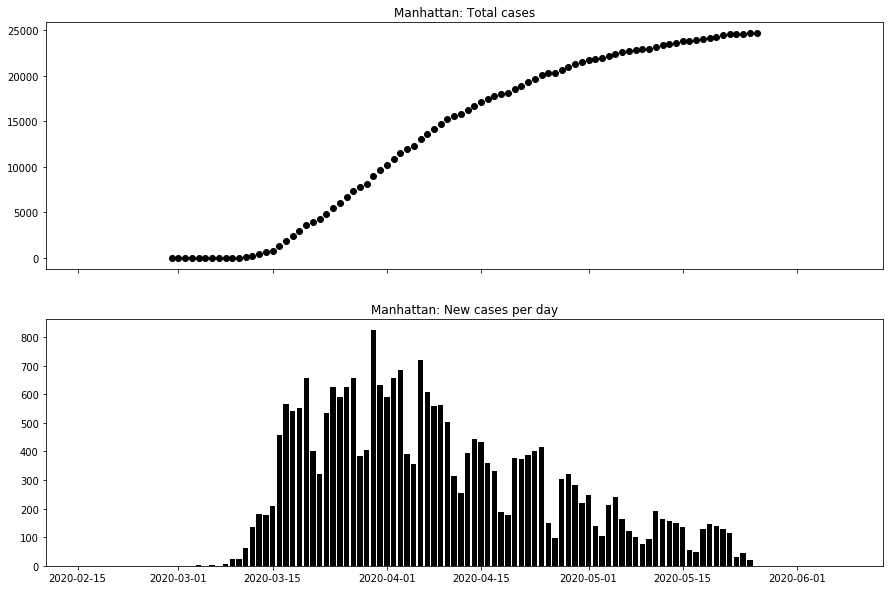

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
ax[0].scatter(mn.index, mn["TotalCases"].values, color="black")
ax[0].set(title="Manhattan: Total cases")
ax[1].bar(mn.index, mn["NewCases"].values, color="black")
ax[1].set(title="Manhattan: New cases per day")
plt.show()

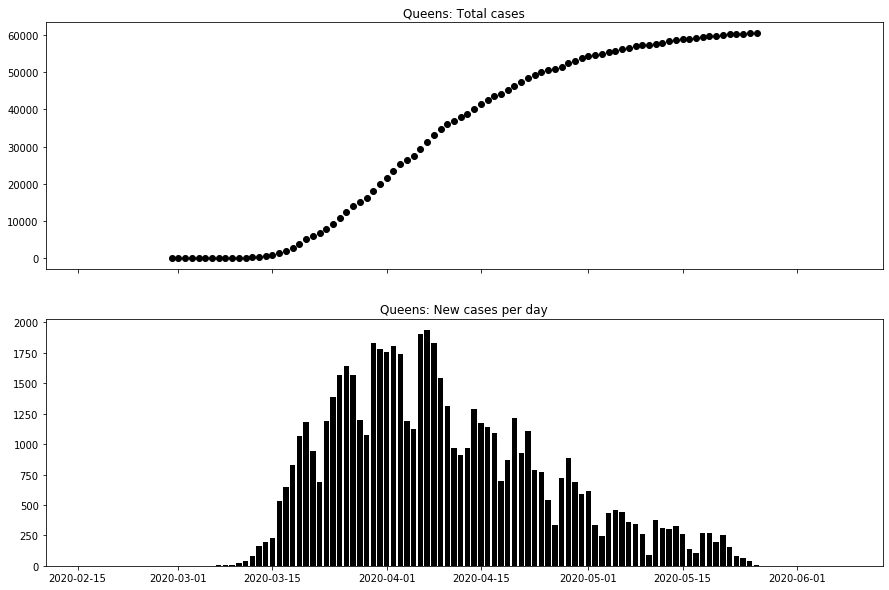

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
ax[0].scatter(qn.index, qn["TotalCases"].values, color="black")
ax[0].set(title="Queens: Total cases")
ax[1].bar(qn.index, qn["NewCases"].values, color="black")
ax[1].set(title="Queens: New cases per day")
plt.show()

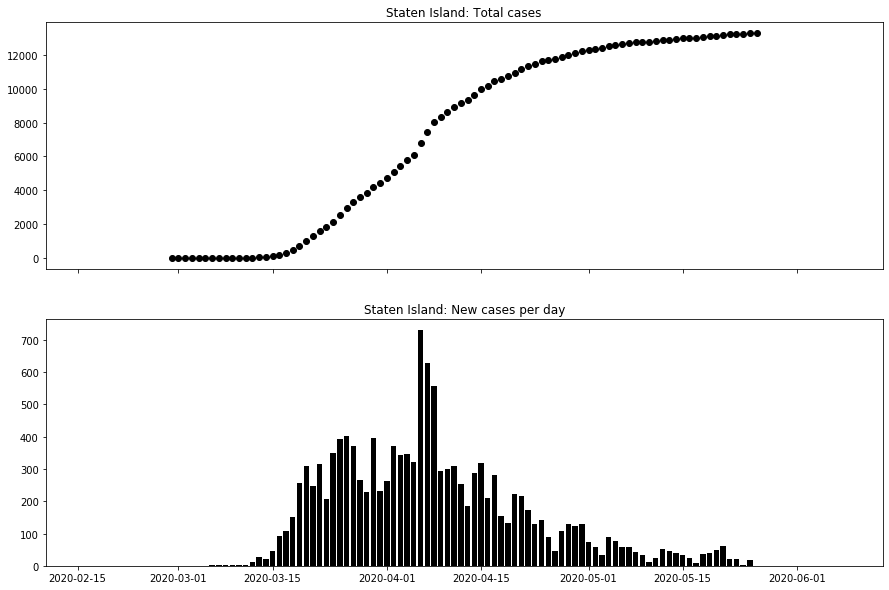

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
ax[0].scatter(si.index, si["TotalCases"].values, color="black")
ax[0].set(title="Staten Island: Total cases")
ax[1].bar(si.index, si["NewCases"].values, color="black")
ax[1].set(title="Staten Island: New cases per day")
plt.show()

In [35]:
bk.describe()

,NewCases,CasesPC,TotalCases
count,88.000000,88.000000,88.000000
mean,616.465909,0.000241,29155.545455
std,491.382215,0.000192,20529.848868
min,0.000000,0.000000,0.000000
25%,185.500000,0.000072,6892.750000
50%,526.500000,0.000206,34211.500000
75%,970.500000,0.000379,48769.500000
max,1744.000000,0.000681,54249.000000


In [36]:
bx.describe()

,NewCases,CasesPC,TotalCases
count,88.000000,88.000000,88.000000
mean,507.340909,0.000358,23486.420455
std,442.223922,0.000312,17408.009316
min,0.000000,0.000000,0.000000
25%,115.000000,0.000081,3671.250000
50%,427.000000,0.000301,27262.000000
75%,836.750000,0.000590,40643.500000
max,1509.000000,0.001064,44646.000000


In [37]:
mn.describe()

,NewCases,CasesPC,TotalCases
count,88.000000,88.000000,88.000000
mean,279.761364,0.000172,13609.238636
std,220.176575,0.000135,9115.708418
min,0.000000,0.000000,1.000000
25%,102.500000,0.000063,4243.750000
50%,215.500000,0.000132,15992.500000
75%,418.750000,0.000257,22219.500000
max,823.000000,0.000505,24619.000000


In [38]:
qn.describe()

,NewCases,CasesPC,TotalCases
count,88.000000,88.000000,88.000000
mean,687.215909,0.000305,32694.420455
std,586.840017,0.000260,23385.782120
min,0.000000,0.000000,0.000000
25%,186.750000,0.000083,6478.000000
50%,565.500000,0.000251,38411.000000
75%,1130.500000,0.000502,55482.000000
max,1934.000000,0.000858,60475.000000


In [39]:
si.describe()

,NewCases,CasesPC,TotalCases
count,88.000000,88.000000,88.000000
mean,150.681818,0.000316,7420.579545
std,155.938431,0.000328,5262.074891
min,0.000000,0.000000,0.000000
25%,25.000000,0.000053,1519.000000
50%,90.500000,0.000190,9252.500000
75%,259.000000,0.000544,12511.250000
max,729.000000,0.001531,13260.000000


#### Observations
Seeing the trends in the graph, we can notice that the number of cases have started to recede and the total cases have nearly saturated,  which might be a consequence of lockdown being imposed.

Seeing the data, we can say that the ideal time to live in a borough would be when the number of new cases are consistently zero which also obviously means the possibility of not contracting the virus will cease to exist at an individual level (in the most ideal scenario). We can perform time series analysis to figure out which borough is the safest, and if possible, also find out which borough will be relatively safer as early as possible. For this, I have used IBM's SPSS modeler and did a time series analysis using the following stream for all boroughs.
* First, I downloaded bk,bx,mn,qn and si by converting them into csv files.
* In each stream, I first added the respective csv file, then figured out the target variable (NewCasesPC), then implemented a time series model and recieved results and made plots with the data from the model. It is represented as (dollar sign)TS-NewCasesPC in the graphs below.  
* The forecast was done for 2 months from when the data was available (26th May onwards). 

_Seeing how important measures have already been taken to contain the virus and a lot of testing has been done, this analysis assumes that number of cases per day have already reached their peak. The data has been normalized for better understanding._


Here's an example of a stream:

![Here's an example of the stream](map.jpg)

### Forecast for Brooklyn


It is observed that there is a repeating pattern from May 27, with the peak being at 0.1719 cases per day and lowest value reaching zero. Which is to say, an individual is 17.19% likely to contract the virus at most. Starting from May 30, the range is between 0-0.1719 cases per head. Let's see the same for other boroughs.

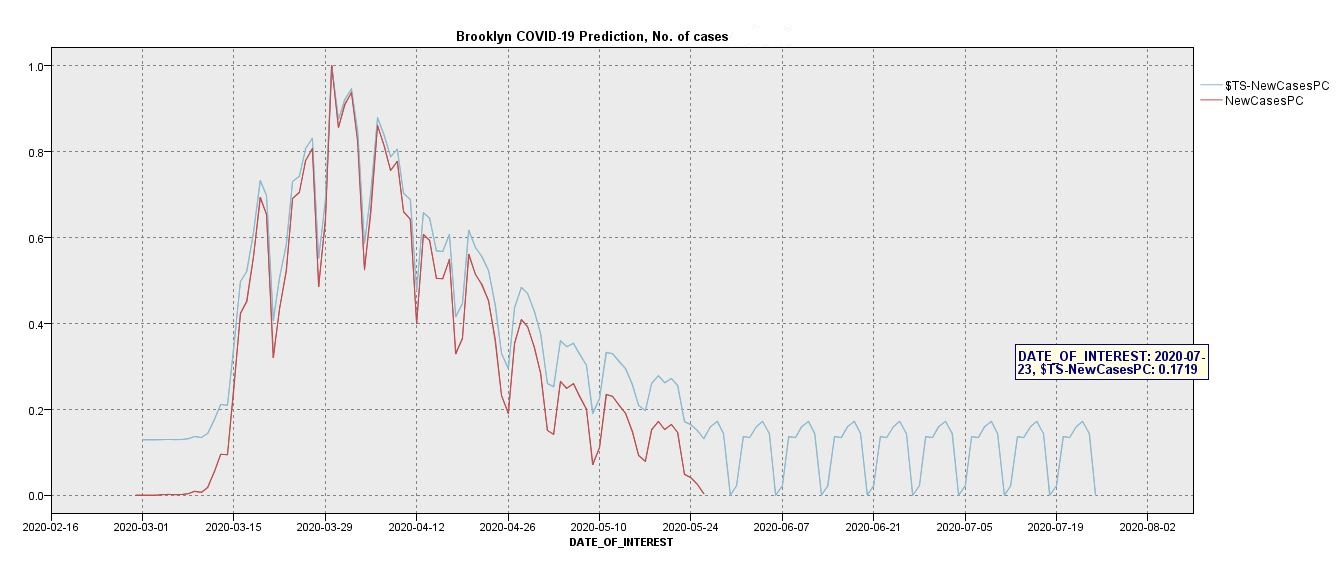

In [40]:
Image("C:\\Users\\MYPC\\Capstone Project\\BKpred.jpg")


### Forecast for Bronx
Peak number of cases per day: 0.1918 (which means an individual is 19.18% likely to contract the virus at most)

Range: 0 to 0.1918 new cases per day (starting from May 31)


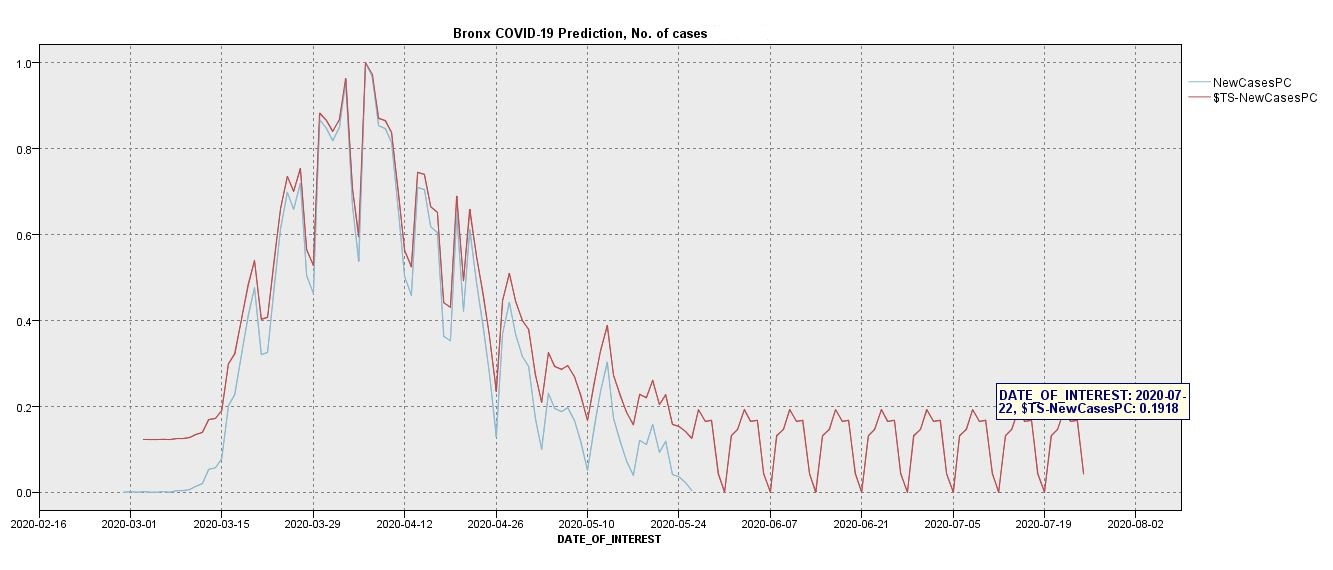

In [41]:
Image("C:\\Users\\MYPC\\Capstone Project\\BXpred.jpg")


### Forecast for Manhattan
Peak number of cases per day: 0.1688 (which means an individual is 16.88% likely to contract the virus at most)

Range: 0 to 0.1688 new cases per day (starting from May 31)


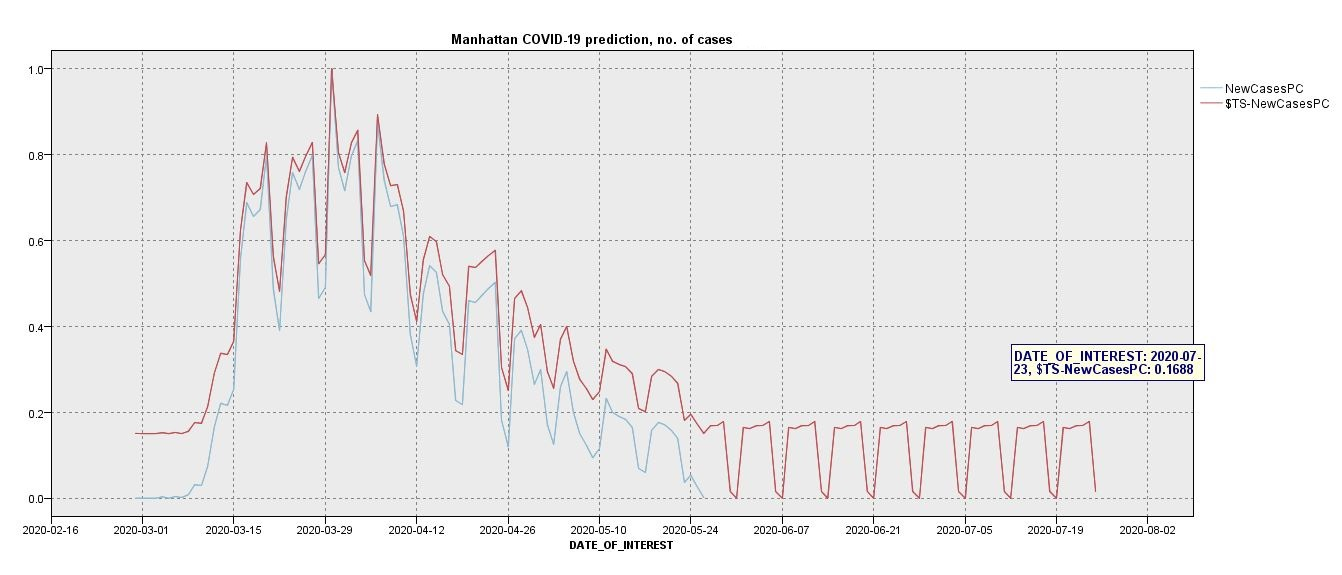

In [42]:
Image("C:\\Users\\MYPC\\Capstone Project\\MNpred.jpg")


### Forecast for Queens
Peak number of cases per day: 0.1720 (which means an individual is 17.20% likely to contract the virus at most)

Range: 0 to 0.1720 new cases per day (starting from May 31)


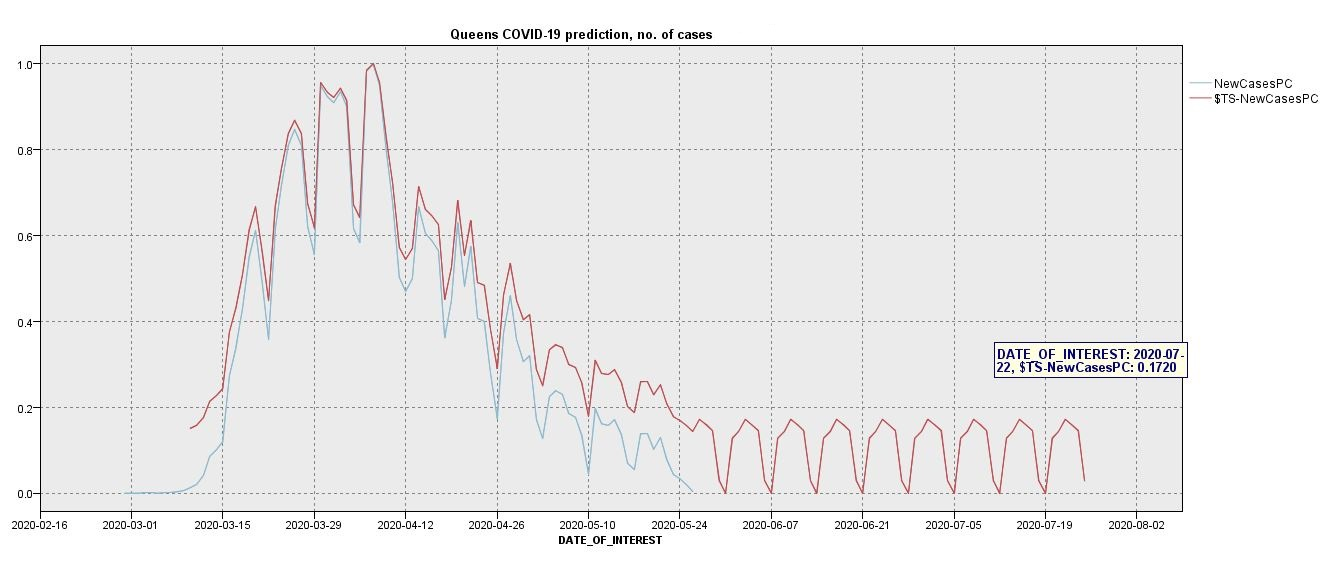

In [43]:
Image("C:\\Users\\MYPC\\Capstone Project\\QNpred.jpg")


### Forecast for Staten Island
Peak number of cases per day: 0.0902 (which means an individual is only 9.02% likely to contract the virus at most)

Range: 0 to 0.0902 new cases per day (starting from May 30)


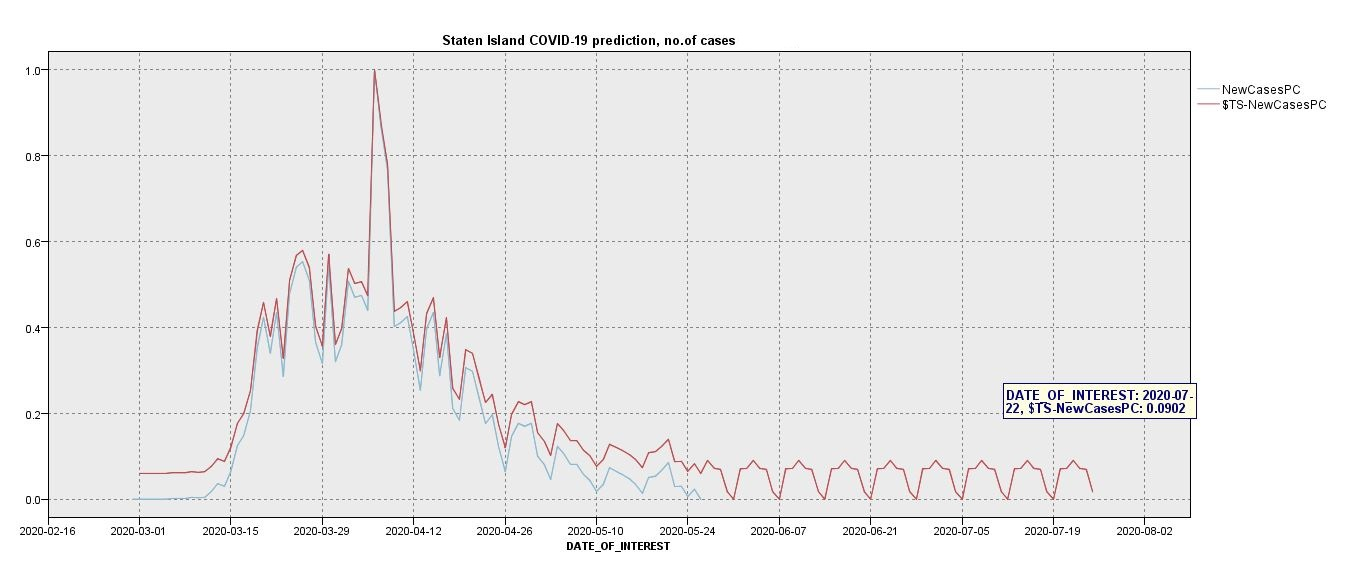

In [44]:
Image("C:\\Users\\MYPC\\Capstone Project\\SIpred.jpg")


According to the model, the virus has been best contained in Manhattan, as the peak value is much lower in number of new cases per day which also means least propensity to be subjected to the virus, making it the safest borough in New York. We shall now further analyze Manhattan and find the most ideal neighborhood.

In [45]:
#getting a map of Manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="mn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [46]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [47]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [48]:
#number of neighborhoods
print(len(manhattan_data['Neighborhood'].unique()))

40


Let's analyze these neighborhoods for COVID-19 statistics.

In [49]:
neigh = pd.read_csv('nyneighborhood.csv')

In [50]:
neigh.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
0,10001,Chelsea - Clinton,Manhattan,358,1519.33,23563.03,21,89.12,17.77
1,10002,Union Square - Lower East Side,Manhattan,1027,1338.02,76755.41,143,186.31,24.53
2,10003,Union Square - Lower East Side,Manhattan,445,827.11,53801.62,32,59.48,14.64
3,10004,Lower Manhattan,Manhattan,31,849.17,3650.61,1,27.39,15.20
4,10005,Lower Manhattan,Manhattan,61,726.53,8396.11,2,23.82,12.79


In [51]:
mncovid=neigh[neigh['BOROUGH_GROUP']=='Manhattan']

In [52]:
mncovid.groupby('NEIGHBORHOOD_NAME').count()

,MODIFIED_ZCTA,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
NEIGHBORHOOD_NAME,,,,,,,,
Central Harlem - Morningside Height,5,5,5,5,5,5,5,5
Chelsea - Clinton,5,5,5,5,5,5,5,5
East Harlem,2,2,2,2,2,2,2,2
Gramercy Park - Murray Hill,4,4,4,4,4,4,4,4
Greenwich Village - Soho,3,3,3,3,3,3,3,3
Lower Manhattan,7,7,7,7,7,7,7,7
Union Square - Lower East Side,3,3,3,3,3,3,3,3
Upper East Side,6,6,6,6,6,6,6,6
Upper West Side,4,4,4,4,4,4,4,4


In [53]:
mncovid=mncovid.drop('MODIFIED_ZCTA',axis=1)
mncovid.head()

,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
0,Chelsea - Clinton,Manhattan,358,1519.33,23563.03,21,89.12,17.77
1,Union Square - Lower East Side,Manhattan,1027,1338.02,76755.41,143,186.31,24.53
2,Union Square - Lower East Side,Manhattan,445,827.11,53801.62,32,59.48,14.64
3,Lower Manhattan,Manhattan,31,849.17,3650.61,1,27.39,15.20
4,Lower Manhattan,Manhattan,61,726.53,8396.11,2,23.82,12.79


In [54]:
temp1 = mncovid.groupby('NEIGHBORHOOD_NAME')['COVID_CASE_COUNT'].sum()
temp2 = mncovid.groupby('NEIGHBORHOOD_NAME')['PERCENT_POSITIVE'].mean()
temp3 = mncovid.groupby('NEIGHBORHOOD_NAME')['COVID_CASE_RATE'].mean()

In [55]:
#Getting case count, percent positive and case rate in a new dataframe
d= {'CaseCount':temp1,'PercentPositive':temp2,'CaseRate':temp3}
mncorona=pd.DataFrame(data=d)
mncorona.head()

,CaseCount,PercentPositive,CaseRate
NEIGHBORHOOD_NAME,,,
Central Harlem - Morningside Height,3158,24.428,1867.592000
Chelsea - Clinton,2069,18.104,1535.208000
East Harlem,2711,28.145,2479.360000
Gramercy Park - Murray Hill,1404,13.585,1009.585000
Greenwich Village - Soho,709,15.090,831.026667


Now, let's clean this dataframe.

In [56]:
mncorona.reset_index(inplace=True)

In [57]:
mncorona

,NEIGHBORHOOD_NAME,CaseCount,PercentPositive,CaseRate
0,Central Harlem - Morningside Height,3158,24.428000,1867.592000
1,Chelsea - Clinton,2069,18.104000,1535.208000
2,East Harlem,2711,28.145000,2479.360000
3,Gramercy Park - Murray Hill,1404,13.585000,1009.585000
4,Greenwich Village - Soho,709,15.090000,831.026667
5,Lower Manhattan,536,14.864286,832.727143
6,Union Square - Lower East Side,2157,19.040000,1110.376667
7,Upper East Side,2608,17.416667,1344.113333
8,Upper West Side,2559,16.365000,1082.575000
9,Washington Heights - Inwood,5836,27.052000,2148.944000


Upon counting, there are only 16 neighborhoods that have been affected, out of 40. We shall now remove the neighborhoods that have been affected from our further analysis as they are comparatively unsafe.

In [58]:
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


In [59]:
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Central Harem'].index
manhattan_data.drop(indexnames,inplace=True)

In [60]:
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Morningside Heights'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Chelsea'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Clinton'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='East Harlem'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Gramercy Park'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Murray Hill'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Greenwich Village'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Soho'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Lower Manhattan'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Union Square'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Lower East Side'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Upper East Side'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Upper West Side'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Washington Heights'].index
manhattan_data.drop(indexnames,inplace=True)
indexnames=manhattan_data[manhattan_data['Neighborhood']=='Inwood'].index
manhattan_data.drop(indexnames,inplace=True)


In [61]:
manhattan_data.reset_index(inplace=True)

In [62]:
manhattan_data.drop(columns=['index'],inplace=True)

In [63]:
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Hamilton Heights,40.823604,-73.949688
3,Manhattan,Manhattanville,40.816934,-73.957385
4,Manhattan,Central Harlem,40.815976,-73.943211


In [64]:
final=pd.read_excel('final_neighborhoods.xlsx')

Since the sources used to extract data from had different ways of considering neighborhoods in Manhattan, manual aggregation was necessary. In an excel sheet, I added population from 2010, which was when the last census took place and it was projected that the population of Manhattan would increase by 3.3% so I put in the same estimation and rounded off the values to calculate the population of the neighborhoods in 2020. Then I added median rent (in this instance, for two bedroom apartments) and median income data to provide an idea of economical conditions of these neighborhoods. For neighborhoods that were an aggregation of 2 or more places, average of latitude and longitude values were used and any neighborhood that contained the places affected by COVID-19 were removed as they were in close vicinty and we need the safest place. We will now look at these data intricately.

In [65]:
final=final.set_index(final['Neighborhood'])
final.head()

,Neighborhood,Median Income,Population 2010,Median Rent,Population 2020,Latitude,Longitude
Neighborhood,,,,,,,
Lincoln Square,Lincoln Square,120337,61489,5232.5,63518,40.773529,-73.985338
Midtown-Midtown South,Midtown-Midtown South,114491,28630,3950.0,29575,40.751601,-73.985191
Turtle Bay-East Midtown,Turtle Bay-East Midtown,113998,51231,3967.0,52922,40.752042,-73.967708
West Village,West Village,112689,66880,4295.0,69087,40.734434,-74.006180
Yorkville,Yorkville,98840,77942,3250.0,80514,40.775930,-73.947118


In [66]:
final.columns

Index(['Neighborhood', 'Median Income', 'Population 2010', 'Median Rent',
       'Population 2020', 'Latitude', 'Longitude'],
      dtype='object')

In [67]:
final.index

Index(['Lincoln Square', 'Midtown-Midtown South', 'Turtle Bay-East Midtown',
       'West Village', 'Yorkville', 'Lenox Hill-Roosevelt Island',
       'Stuyvesant Town-Cooper Village', 'East Village',
       'Central Harlem South', 'Hamilton Heights', 'Chinatown',
       'Central Harlem North-Polo Grounds', 'Manhattanville'],
      dtype='object', name='Neighborhood')

In [68]:
final.drop('Neighborhood',axis=1,inplace=True)

In [69]:
final.head()

,Median Income,Population 2010,Median Rent,Population 2020,Latitude,Longitude
Neighborhood,,,,,,
Lincoln Square,120337,61489,5232.5,63518,40.773529,-73.985338
Midtown-Midtown South,114491,28630,3950.0,29575,40.751601,-73.985191
Turtle Bay-East Midtown,113998,51231,3967.0,52922,40.752042,-73.967708
West Village,112689,66880,4295.0,69087,40.734434,-74.006180
Yorkville,98840,77942,3250.0,80514,40.775930,-73.947118


The range of values are: 
120337 29182


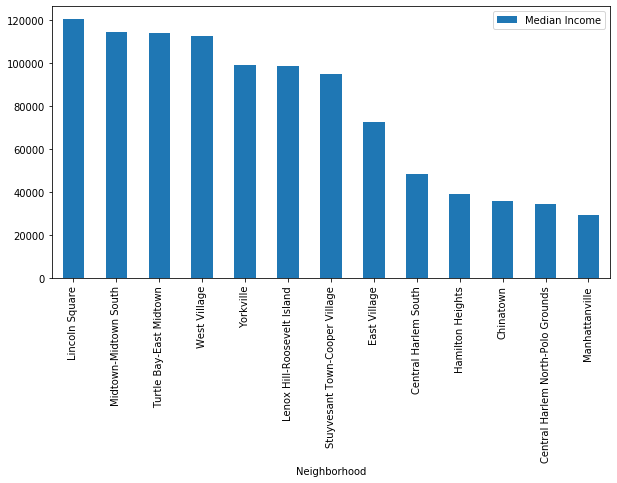

In [70]:
_=final.plot.bar(y='Median Income',figsize=(10,5))
print('The range of values are: ')
print(final['Median Income'].max(),final['Median Income'].min())

The range of values are: 
83436 21744


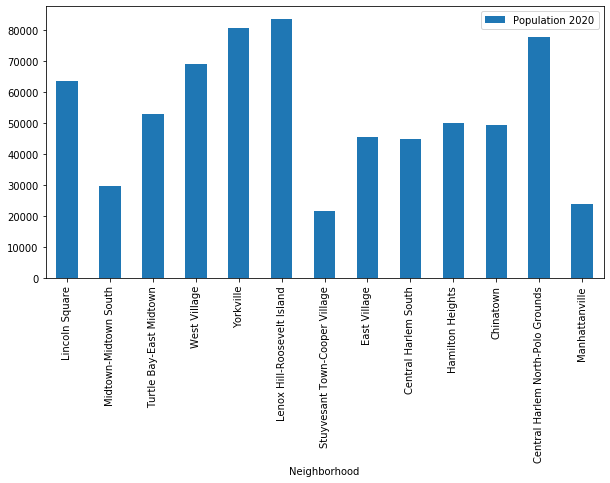

In [71]:
_=final.plot.bar(y='Population 2020',figsize=(10,5))
print('The range of values are: ')
print(final['Population 2020'].max(),final['Population 2020'].min())

The range of values are: 
5232.5 2300.0


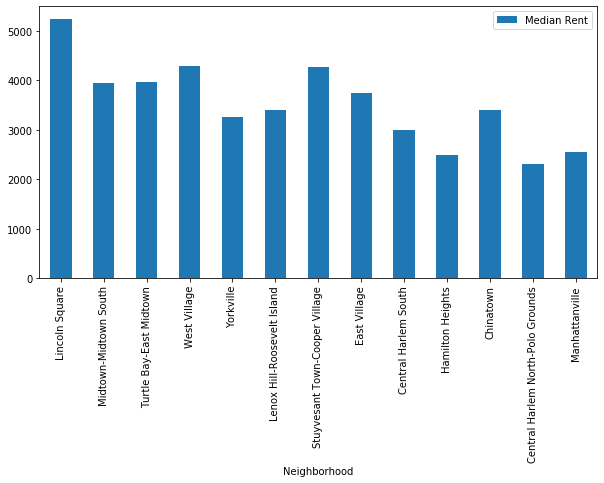

In [72]:
_=final.plot.bar(y='Median Rent',figsize=(10,5))
print('The range of values are: ')
print(final['Median Rent'].max(),final['Median Rent'].min())

In [73]:
final.reset_index(inplace=True)
# creating map of Manhattan using latitude and longitude values
finalmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, label in zip(final['Latitude'], final['Longitude'], final['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(finalmap)  
    
finalmap

These are the safest neighborhoods in Manhattan. Using FourSquare API, we shall now explore these neighborhoods.

In [79]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20200606' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' )
print('CLIENT_SECRET:' )

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [75]:
df=final.reset_index()

In [76]:
LIMIT=300
radius= 1500

In [77]:
#function to generate the nearby venues.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
manhattan_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Lincoln Square
Midtown-Midtown South
Turtle Bay-East Midtown
West Village
Yorkville
Lenox Hill-Roosevelt Island
Stuyvesant Town-Cooper Village
East Village
Central Harlem South
Hamilton Heights
Chinatown
Central Harlem North-Polo Grounds
Manhattanville


In [81]:
print(manhattan_venues.shape)
manhattan_venues

(927, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lincoln Square,40.773529,-73.985338,The Metropolitan Opera (Metropolitan Opera),40.772742,-73.984401,Opera House
1,Lincoln Square,40.773529,-73.985338,Vivian Beaumont Theater,40.773354,-73.983827,Theater
2,Lincoln Square,40.773529,-73.985338,American Ballet Theatre,40.772668,-73.984476,Performing Arts Venue
3,Lincoln Square,40.773529,-73.985338,Walter Reade Theater,40.773783,-73.983924,Indie Movie Theater
4,Lincoln Square,40.773529,-73.985338,New York Philharmonic,40.772526,-73.983139,Concert Hall
5,Lincoln Square,40.773529,-73.985338,New York Public Library for the Performing Art...,40.773874,-73.985041,Library
6,Lincoln Square,40.773529,-73.985338,The Juilliard School,40.773749,-73.982829,College Arts Building
7,Lincoln Square,40.773529,-73.985338,David H. Koch Theater,40.772292,-73.983262,Theater
8,Lincoln Square,40.773529,-73.985338,Claire Tow Theater,40.773365,-73.984051,Theater
9,Lincoln Square,40.773529,-73.985338,Big Apple Circus,40.772132,-73.985348,Circus


In [82]:
manhattan_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
African Restaurant,3,3,3,3,3,3
American Restaurant,19,19,19,19,19,19
Arepa Restaurant,1,1,1,1,1,1
Argentinian Restaurant,1,1,1,1,1,1
Art Gallery,4,4,4,4,4,4
Arts & Crafts Store,1,1,1,1,1,1
Asian Restaurant,4,4,4,4,4,4
Athletics & Sports,2,2,2,2,2,2
Austrian Restaurant,2,2,2,2,2,2


In [83]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 225 uniques categories.


In [84]:
ls=manhattan_venues[manhattan_venues['Neighborhood']=='Lincoln Square']
mms=manhattan_venues[manhattan_venues['Neighborhood']=='Midtown-Midtown South']
tbem=manhattan_venues[manhattan_venues['Neighborhood']=='Turtle Bay-East Midtown']
wv=manhattan_venues[manhattan_venues['Neighborhood']=='West Village']
yv=manhattan_venues[manhattan_venues['Neighborhood']=='Yorkville']
lhri=manhattan_venues[manhattan_venues['Neighborhood']=='Lenox Hill-Roosevelt Island']
stcv=manhattan_venues[manhattan_venues['Neighborhood']=='Stuyvesant Town-Cooper Village']
ev=manhattan_venues[manhattan_venues['Neighborhood']=='East Village']
chs=manhattan_venues[manhattan_venues['Neighborhood']=='Central Harlem South']
hh=manhattan_venues[manhattan_venues['Neighborhood']=='Hamilton Heights']
ct=manhattan_venues[manhattan_venues['Neighborhood']=='Chinatown']
chnpg=manhattan_venues[manhattan_venues['Neighborhood']=='Central Harlem North-Polo Grounds']
mv=manhattan_venues[manhattan_venues['Neighborhood']=='Manhattanville']

This is what the new dataframe looks like.

In [85]:
ls.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lincoln Square,40.773529,-73.985338,The Metropolitan Opera (Metropolitan Opera),40.772742,-73.984401,Opera House
1,Lincoln Square,40.773529,-73.985338,Vivian Beaumont Theater,40.773354,-73.983827,Theater
2,Lincoln Square,40.773529,-73.985338,American Ballet Theatre,40.772668,-73.984476,Performing Arts Venue
3,Lincoln Square,40.773529,-73.985338,Walter Reade Theater,40.773783,-73.983924,Indie Movie Theater
4,Lincoln Square,40.773529,-73.985338,New York Philharmonic,40.772526,-73.983139,Concert Hall


In [86]:
print('Number of venues in Lincoln Square: {}'.format(ls['Venue'].count()))
print('Number of venues in Midtown-Midtown South: {}'.format(mms['Venue'].count()))
print('Number of venues in Turtle Bay-East Midtown: {}'.format(tbem['Venue'].count()))
print('Number of venues in West Village: {}'.format(wv['Venue'].count()))
print('Number of venues in Yorkville: {}'.format(yv['Venue'].count()))
print('Number of venues in Lenox Hill-Roosevelt Island: {}'.format(lhri['Venue'].count()))
print('Number of venues in Stuyvesant Town-Cooper Village: {}'.format(stcv['Venue'].count()))
print('Number of venues in East Village: {}'.format(ev['Venue'].count()))
print('Number of venues in Central Harlem South: {}'.format(chs['Venue'].count()))
print('Number of venues in Hamilton Heights: {}'.format(hh['Venue'].count()))
print('Number of venues in Chinatown: {}'.format(ct['Venue'].count()))
print('Number of venues in Central Harlem North-Polo Grounds: {}'.format(chnpg['Venue'].count()))
print('Number of venues in Manhattanville: {}'.format(mv['Venue'].count()))

Number of venues in Lincoln Square: 98
Number of venues in Midtown-Midtown South: 95
Number of venues in Turtle Bay-East Midtown: 100
Number of venues in West Village: 100
Number of venues in Yorkville: 100
Number of venues in Lenox Hill-Roosevelt Island: 36
Number of venues in Stuyvesant Town-Cooper Village: 18
Number of venues in East Village: 100
Number of venues in Central Harlem South: 46
Number of venues in Hamilton Heights: 60
Number of venues in Chinatown: 100
Number of venues in Central Harlem North-Polo Grounds: 35
Number of venues in Manhattanville: 39


In [87]:
final=final.set_index(final['Neighborhood'])
sort_by_population=final.sort_values('Population 2020',ascending=False)
sort_by_population.loc[:,'Population 2020']

Neighborhood
Lenox Hill-Roosevelt Island          83436
Yorkville                            80514
Central Harlem North-Polo Grounds    77766
West Village                         69087
Lincoln Square                       63518
Turtle Bay-East Midtown              52922
Hamilton Heights                     50121
Chinatown                            49423
East Village                         45592
Central Harlem South                 44815
Midtown-Midtown South                29575
Manhattanville                       23707
Stuyvesant Town-Cooper Village       21744
Name: Population 2020, dtype: int64

In [88]:
print('Mean population: {}'.format(sort_by_population['Population 2020'].mean()))

Mean population: 53247.692307692305


In [89]:
sort_by_income=final.sort_values('Median Income',ascending=False)
sort_by_income.loc[:,'Median Income']

Neighborhood
Lincoln Square                       120337
Midtown-Midtown South                114491
Turtle Bay-East Midtown              113998
West Village                         112689
Yorkville                             98840
Lenox Hill-Roosevelt Island           98797
Stuyvesant Town-Cooper Village        95022
East Village                          72665
Central Harlem South                  48366
Hamilton Heights                      39019
Chinatown                             35908
Central Harlem North-Polo Grounds     34413
Manhattanville                        29182
Name: Median Income, dtype: int64

In [90]:
print('Mean of median income: {}'.format(sort_by_population['Median Income'].mean()))

Mean of median income: 77979.0


In [91]:
sort_by_rent=final.sort_values('Median Rent')
sort_by_rent.loc[:,'Median Rent']

Neighborhood
Central Harlem North-Polo Grounds    2300.0
Hamilton Heights                     2495.0
Manhattanville                       2550.0
Central Harlem South                 3000.0
Yorkville                            3250.0
Chinatown                            3391.0
Lenox Hill-Roosevelt Island          3395.0
East Village                         3750.0
Midtown-Midtown South                3950.0
Turtle Bay-East Midtown              3967.0
Stuyvesant Town-Cooper Village       4256.5
West Village                         4295.0
Lincoln Square                       5232.5
Name: Median Rent, dtype: float64

In [92]:
print('Mean of median rent: {}'.format(sort_by_population['Median Rent'].mean()))

Mean of median rent: 3525.5384615384614


#### Observation
* Lincoln Square, West Village, Turtle Bay-East Midtown, are well-off neighborhoods in this list with a lot of venues in the city, and the standard of living is high. The population is above average too, so there is a decent scope to get good customers. On the contrary, Lenox Hill-Roosevelt Island and Yorkville, while having big population size and being above-average economically, have more affordable rent in comparison. 
* Yorkville also has a lot of venues nearby. Lenox Hill-Roosevelt Island has a comparatively untapped market when compared to other neighborhoods.
* East Village is also financially feasible and has above average quality of living with a lot of venues, but the population is relatively low. 
* Manhattanville is not so well-off in comparison and has a sparse population. The market is also quite dire.
* Stuyvesant Town-Cooper Village and Midtown-Midtown South have high standard of living and mostly well-off residents but the population is pretty low.
* Chinatown is not-so-well-off and its population size is about average. But there are a lot of venues.
* Central Harlem North-Polo Grounds has a high population but the residents are not as rich as other places and the standard of living is also the lowest.
* The remaining options are moderate.

In [93]:
print('The total number of safe restaurants in Manhattan are {}'.format(len(manhattan_venues[manhattan_venues['Venue Category'].str.contains('Restaurant')])))

The total number of safe restaurants in Manhattan are 264


In [94]:
ls[ls['Venue Category'].str.contains('Restaurant')].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30,Lincoln Square,40.773529,-73.985338,The Smith,40.771505,-73.982292,American Restaurant
33,Lincoln Square,40.773529,-73.985338,Dig Inn,40.774260,-73.981500,American Restaurant
35,Lincoln Square,40.773529,-73.985338,Boulud Sud,40.771930,-73.981576,Mediterranean Restaurant
42,Lincoln Square,40.773529,-73.985338,Nanoosh,40.775823,-73.982204,Mediterranean Restaurant
43,Lincoln Square,40.773529,-73.985338,Bar Boulud,40.771859,-73.982301,French Restaurant


In [95]:
print('Number of restaurants in Lincoln Square: {}'.format(len(ls[ls['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Midtown-Midtown South: {}'.format(len(mms[mms['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Turtle Bay-East Midtown: {}'.format(len(tbem[tbem['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in West Village: {}'.format(len(wv[wv['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Yorkville: {}'.format(len(yv[yv['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Lenox Hill-Roosevelt Island: {}'.format(len(lhri[lhri['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Stuyvesant Town-Cooper Village: {}'.format(len(stcv[stcv['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in East Village: {}'.format(len(ev[ev['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Central Harlem South: {}'.format(len(chs[chs['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Hamilton Heights: {}'.format(len(hh[hh['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Chinatown: {}'.format(len(ct[ct['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Central Harlem North-Polo Grounds: {}'.format(len(chnpg[chnpg['Venue Category'].str.contains('Restaurant')])))
print('Number of restaurants in Manhattanville: {}'.format(len(mv[mv['Venue Category'].str.contains('Restaurant')])))

Number of restaurants in Lincoln Square: 17
Number of restaurants in Midtown-Midtown South: 27
Number of restaurants in Turtle Bay-East Midtown: 35
Number of restaurants in West Village: 25
Number of restaurants in Yorkville: 29
Number of restaurants in Lenox Hill-Roosevelt Island: 9
Number of restaurants in Stuyvesant Town-Cooper Village: 0
Number of restaurants in East Village: 36
Number of restaurants in Central Harlem South: 14
Number of restaurants in Hamilton Heights: 17
Number of restaurants in Chinatown: 36
Number of restaurants in Central Harlem North-Polo Grounds: 2
Number of restaurants in Manhattanville: 17


This is what the new visualization of the neighborhoods with their venues looks like.

In [96]:
venuemap = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_venues['Venue Latitude'], manhattan_venues['Venue Longitude'], manhattan_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#07E311',
        fill_opacity=0.7,
        parse_html=False).add_to(venuemap)  
    
venuemap

In [97]:
mnrest=manhattan_venues[manhattan_venues['Venue Category'].str.contains('Restaurant')]

In [98]:
mnrest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30,Lincoln Square,40.773529,-73.985338,The Smith,40.771505,-73.982292,American Restaurant
33,Lincoln Square,40.773529,-73.985338,Dig Inn,40.774260,-73.981500,American Restaurant
35,Lincoln Square,40.773529,-73.985338,Boulud Sud,40.771930,-73.981576,Mediterranean Restaurant
42,Lincoln Square,40.773529,-73.985338,Nanoosh,40.775823,-73.982204,Mediterranean Restaurant
43,Lincoln Square,40.773529,-73.985338,Bar Boulud,40.771859,-73.982301,French Restaurant


Now, let's see the visualization of the restaurants in these neighborhoods. 

In [99]:
restmap = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(mnrest['Venue Latitude'], mnrest['Venue Longitude'], mnrest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#07E311',
        fill_opacity=0.7,
        parse_html=False).add_to(restmap)  
    
restmap

In [100]:
# one hot encoding
manhattan_onehot = pd.get_dummies(mnrest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = mnrest['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
30,Lincoln Square,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,Lincoln Square,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,Lincoln Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,Lincoln Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,Lincoln Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Central Harlem North-Polo Grounds,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
1,Central Harlem South,0.214286,0.142857,0.000000,0.000000,0.000000,0.000000,0.00,0.071429,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chinatown,0.000000,0.083333,0.000000,0.000000,0.055556,0.027778,0.00,0.000000,0.194444,0.000000,0.000000,0.055556,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.027778,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.055556,0.000000,0.055556,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.027778,0.000000,0.027778,0.083333
3,East Village,0.000000,0.027778,0.027778,0.027778,0.000000,0.000000,0.00,0.027778,0.027778,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.138889,0.027778,0.027778,0.000000,0.000000,0.055556,0.000000,0.027778,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.027778,0.027778,0.027778,0.027778,0.000000,0.055556,0.055556
4,Hamilton Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.117647,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.058824,0.000000,0.058824,0.000000,0.058824,0.000000,0.058824,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Lenox Hill-Roosevelt Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Lincoln Square,0.000000,0.17647

In [102]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Harlem North-Polo Grounds----
                      venue  freq
0        Seafood Restaurant   0.5
1          Tapas Restaurant   0.5
2        African Restaurant   0.0
3          Malay Restaurant   0.0
4  Mediterranean Restaurant   0.0


----Central Harlem South----
                 venue  freq
0   African Restaurant  0.21
1  American Restaurant  0.14
2    French Restaurant  0.14
3   Seafood Restaurant  0.14
4   Chinese Restaurant  0.14


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.19
1  Vietnamese Restaurant  0.08
2    American Restaurant  0.08
3       Greek Restaurant  0.06
4       Asian Restaurant  0.06


----East Village----
                           venue  freq
0             Mexican Restaurant  0.14
1            Japanese Restaurant  0.08
2          Vietnamese Restaurant  0.06
3               Ramen Restaurant  0.06
4  Vegetarian / Vegan Restaurant  0.06


----Hamilton Heights----
                  venue  freq
0    Mexican Restaurant  0.18

In [103]:
def return_most_common_restaurants(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_restaurants(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Harlem North-Polo Grounds,Seafood Restaurant,Tapas Restaurant,Dim Sum Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
1,Central Harlem South,African Restaurant,Chinese Restaurant,French Restaurant,Seafood Restaurant,American Restaurant,Ethiopian Restaurant,Caribbean Restaurant,Southern / Soul Food Restaurant,Argentinian Restaurant,Indian Restaurant
2,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Malay Restaurant,Mexican Restaurant,Shanghai Restaurant,Dim Sum Restaurant,Greek Restaurant,English Restaurant
3,East Village,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant,Filipino Restaurant,Greek Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Vietnamese Restaurant,Swiss Restaurant
4,Hamilton Heights,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Seafood Restaurant
5,Lenox Hill-Roosevelt Island,Sushi Restaurant,Greek Restaurant,Japanese Restaurant,Mexican Restaurant,Cuban Restaurant,Czech Restaurant,English Restaurant,Indian Restaurant,Hotpot Restaurant,German Restaurant
6,Lincoln Square,Italian Restaurant,American Restaurant,French Restaurant,Mediterranean Restaurant,Seafood Restaurant,Greek Restaurant,Mexican Restaurant,Chinese Restaurant,English Restaurant,Hotpot Restaurant
7,Manhattanville,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Chinese Restaurant,Dumpling Restaurant,Ramen Restaurant,Cuban Restaurant,Falafel Restaurant,Spanish Restaurant
8,Midtown-Midtown South,Korean Restaurant,Japanese Restaurant,Mediterranean Restaurant,American Restaurant,Chinese Restaurant,Cuban Restaurant,Turkish Restaurant,Italian Restaurant,Ramen Restaurant,Sushi Restaurant
9,Turtle Bay-East Midtown,Italian Restaurant,Sushi Restaurant,French Restaurant,Seafood Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant,Turkish Restaurant,Thai Restaurant,American Restaurant


In [105]:
# set number of clusters
kclusters = 4

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 0, 2, 2, 2, 1, 2, 0, 2])

In [106]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [107]:
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan,Chinatown,40.715618,-73.994279,0.0,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Malay Restaurant,Mexican Restaurant,Shanghai Restaurant,Dim Sum Restaurant,Greek Restaurant,English Restaurant
2,Manhattan,Hamilton Heights,40.823604,-73.949688,2.0,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Seafood Restaurant
3,Manhattan,Manhattanville,40.816934,-73.957385,2.0,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Chinese Restaurant,Dumpling Restaurant,Ramen Restaurant,Cuban Restaurant,Falafel Restaurant,Spanish Restaurant
4,Manhattan,Central Harlem,40.815976,-73.943211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
manhattan_merged.dropna(inplace=True)

In [109]:
manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,40.715618,-73.994279,0.0,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Malay Restaurant,Mexican Restaurant,Shanghai Restaurant,Dim Sum Restaurant,Greek Restaurant,English Restaurant
2,Manhattan,Hamilton Heights,40.823604,-73.949688,2.0,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Seafood Restaurant
3,Manhattan,Manhattanville,40.816934,-73.957385,2.0,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Chinese Restaurant,Dumpling Restaurant,Ramen Restaurant,Cuban Restaurant,Falafel Restaurant,Spanish Restaurant
5,Manhattan,Yorkville,40.775930,-73.947118,2.0,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant,Turkish Restaurant,French Restaurant,Thai Restaurant
8,Manhattan,Lincoln Square,40.773529,-73.985338,1.0,Italian Restaurant,American Restaurant,French Restaurant,Mediterranean Restaurant,Seafood Restaurant,Greek Restaurant,Mexican Restaurant,Chinese Restaurant,English Restaurant,Hotpot Restaurant
10,Manhattan,East Village,40.727847,-73.982226,2.0,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant,Filipino Restaurant,Greek Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Vietnamese Restaurant,Swiss Restaurant
13,Manhattan,West Village,40.734434,-74.006180,1.0,Italian Restaurant,American Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Falafel Restaurant


In [110]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
         color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [111]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Malay Restaurant,Mexican Restaurant,Shanghai Restaurant,Dim Sum Restaurant,Greek Restaurant,English Restaurant


In [112]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Lincoln Square,Italian Restaurant,American Restaurant,French Restaurant,Mediterranean Restaurant,Seafood Restaurant,Greek Restaurant,Mexican Restaurant,Chinese Restaurant,English Restaurant,Hotpot Restaurant
13,West Village,Italian Restaurant,American Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Falafel Restaurant


In [113]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Hamilton Heights,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Seafood Restaurant
3,Manhattanville,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Chinese Restaurant,Dumpling Restaurant,Ramen Restaurant,Cuban Restaurant,Falafel Restaurant,Spanish Restaurant
5,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant,Turkish Restaurant,French Restaurant,Thai Restaurant
10,East Village,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant,Filipino Restaurant,Greek Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Vietnamese Restaurant,Swiss Restaurant


#### Observations
* Untapped markets: Lenox Hill-Roosevelt Island, Stuyvesant Town-Cooper Village, Central Harlem North-Polo Grounds
* High competition: Chinatown, East Village, Turtle Bay-East Midtown, Midtown-Midtown South, Yorkville
* Other neighborhoods have moderate competition.
* The most popular cuisine is Italian in these locations, followed by American, Japanese/Sushi, Mexican and Chinese. The comepetition in opening a restaurant for these cuisines will be very high.
* There is a scope to open more ethnic restaurants in these parts.
* Ideally, having some representation of popular cusines in the restaurant will be beneficial, especially Italian cuisines like pizza and spaghetti. It can serve to be a comfort food.
* New Indian, Vietnamese or Filipino cuisine restaurants can potentially compete better in this climate with their existing counterparts, since they are lower in number.

Now, let's visualize the farmer's market in Manhattan.

In [114]:
fm=pd.read_csv('DOHMH_Farmers_Markets.csv')

In [115]:
fm.head()

,Borough,Market Name,Street Address,Latitude,Longitude,Days of Operation,Hours of Operations,Season Dates,Accepts EBT,Open Year-Round,Stellar Cooking Demonstrations,Food Activities for Kids,Location Point
0,Brooklyn,Urban Oasis Farmers' Market,681 Clarkson Ave.,40.656255,-73.936608,Wednesday,2pm-5:30pm,06/24/20-11/04/20,No,No,NaN,NaN,"(40.656255, -73.936608)"
1,Staten Island,Goodhue Center Go!Healthy Farm Stand,301 Prospect Ave,40.638983,-74.097422,Tuesday,11am-2pm,07/06/20-11/20/20,Yes,No,NaN,NaN,"(40.638983, -74.097422)"
2,Manhattan,Morningside Park's Down to Earth Farmers' Market,W 110th St & Manhattan Ave,40.801155,-73.959647,Saturday,9am-4pm (winter closes at 3pm),Year-Round,Yes,Yes,NaN,NaN,"(40.801155, -73.959647)"
3,Bronx,170 Farm Stand,E 170th St & Townsend Ave,40.839882,-73.916783,Wednesday,2:30pm-6:30pm,7/15/20-11/25/20,Yes,No,NaN,NaN,"(40.839882, -73.916783)"
4,Manhattan,Go!Healthy Farm Stand at Mirabal Sisters Campus,21 Jumel Pl.,40.839305,-73.936159,Friday,11am-2pm,07/07/2020-11/20/20,Yes,No,NaN,NaN,"(40.839305, -73.936159)"


In [116]:
fm=fm[fm['Borough']=='Manhattan']

In [117]:
fm.head()

,Borough,Market Name,Street Address,Latitude,Longitude,Days of Operation,Hours of Operations,Season Dates,Accepts EBT,Open Year-Round,Stellar Cooking Demonstrations,Food Activities for Kids,Location Point
2,Manhattan,Morningside Park's Down to Earth Farmers' Market,W 110th St & Manhattan Ave,40.801155,-73.959647,Saturday,9am-4pm (winter closes at 3pm),Year-Round,Yes,Yes,NaN,NaN,"(40.801155, -73.959647)"
4,Manhattan,Go!Healthy Farm Stand at Mirabal Sisters Campus,21 Jumel Pl.,40.839305,-73.936159,Friday,11am-2pm,07/07/2020-11/20/20,Yes,No,NaN,NaN,"(40.839305, -73.936159)"
5,Manhattan,Union Square Greenmarket,E 17th St & Union Square W,40.737133,-73.990329,Monday \nWednesday\nFriday\nSaturday,8am - 6pm,Year-Round,Yes,Yes,NaN,NaN,"(40.737133, -73.990329)"
16,Manhattan,Stuyvesant Town Greenmarket,"E. 14th. St. Loop & Avenue A, in the Oval",40.730443,-73.980339,Sunday,9:30am - 4pm,5/17/20-12/20/20,Yes,No,NaN,NaN,"(40.730443, -73.980339)"
20,Manhattan,Harvest Home 125th Street Market,W 125th St & Adam Clayton Powell Jr Blvd,40.808973,-73.948325,Tuesday,8am-6pm,TBD,Yes,No,NaN,NaN,"(40.808973, -73.948325)"


In [118]:
# creating map of Manhattan using latitude and longitude values
fmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, label in zip(fm['Latitude'], fm['Longitude'], fm['Market Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(fmap)  
    
fmap

We can see that almost every neighborhood has farmer's market so retrieving ingredients won't be a difficult task. There is a scope to import from elsewhere as well but until the situation remains volatile, we can't be sure about doing so. Hence, buying ingredients from the closest proximity is the way to go.